In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
common			  experiments		   index.py		  README.md
config.yaml		  get_dataset.sh	   last_run_info.json	  SINet.ipynb
datautils		  get_info.py		   models		  source-data
demo			  github-repo-clone.ipynb  output		  test_seg.py
excluded-train-files.txt  Index.ipynb		   preprocess_dataset.py  texture_params.txt


In [ ]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="source-data"

if not(os.path.exists("source-data")):
    #!gdown https://drive.google.com/uc?id=18oBjWeuw5qAq4HG_jZdjUHas4APy-KJE&export=download
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d . ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./source-data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")


The data directory exists!


In [ ]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import json

from experiments.style_transfer import style_transfer, run_style_transfer_pipeline
from common.visualizer import layer_visualizer
from common.utils import init_config

In [ ]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
config_params = init_config()
print(config_params)

{'data_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/source-data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/output', 'root_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project', 'use_gpu': True}


In [ ]:

param_dict = {
    'moss': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'snow': {
        'epochs': 200,
        'style_weights': 1.5
    },
    'wet-sand': {
        'epochs': 200,
        'style_weights': 3.5
    },
    'sand-with-moss': {
        'epochs': 100,
        'style_weights': 2.5
    },
    'rain': {
        'epochs': 100,
        'style_weights': 4.5
    },
    'wood': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'grass': {
        'epochs': 100,
        'style_weights': 0.1
    },
    'foliage-texture': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'blue-coral': {
        'epochs': 100,
        'style_weights': 1.1
    }
}

with open("./last_run_info.json") as fp:
    last_run = json.load(fp)["last_batch"]

selected_textures = ['moss', 'wet-sand', 'sand-with-moss', 'rain', 'foliage-texture']

for texture in selected_textures:

    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type = int, default = 1)
    parser.add_argument('--model_name', type=str, default='vgg')
    parser.add_argument('--lr', type=float, default=0.05)
    parser.add_argument('--max_iter', type=int, default=param_dict[texture]['epochs'])
    args = parser.parse_args(args=[])

    #style_img = read_image(f'./data/Textures/{texture}.jpg')
    #print(img.size())
    #layer_visualizer(img, args)

    run_style_transfer_pipeline(args, texture, param_dict[texture]['style_weights'], last_run)

Running epoch 0


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 1


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.48s/it]


Running epoch 2


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 3


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Running epoch 4


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.45s/it]


Running epoch 5


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.43s/it]


Running epoch 6


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.46s/it]


Running epoch 7


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.43s/it]


Running epoch 8


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 9


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.44s/it]


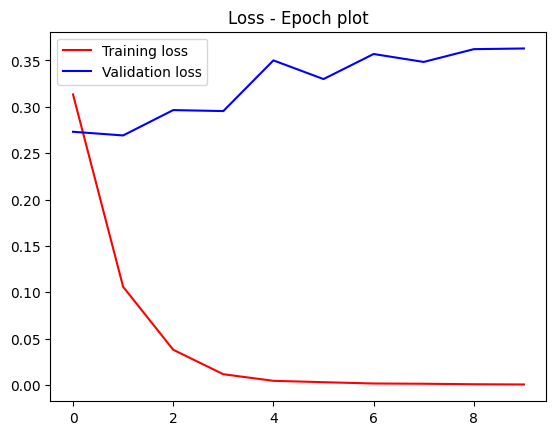

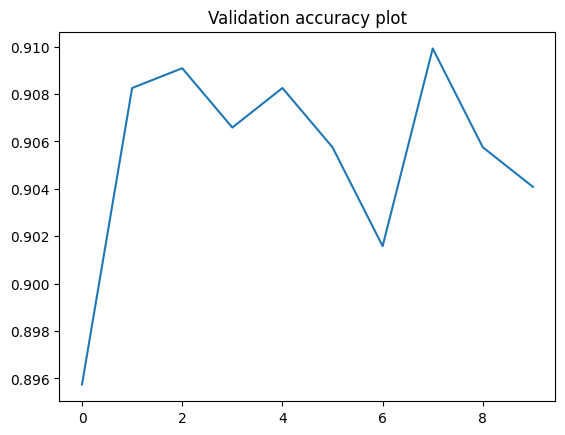

Running through test set: 100%|██████████| 63/63 [02:31<00:00,  2.41s/it]



Test accuracy:  tensor(0.9080)


In [ ]:
from experiments.classification import Classification

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 64)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--max_iter', type=int, default=10)
parser.add_argument('--resize_size', type=int, default=224)
args = parser.parse_args(args=[])

classification = Classification()

classification.run_binary_classification_pipeline(args)
